In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
import category_encoders as ce 
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from datetime import datetime
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


In [2]:
train = pickle.load(open('c_train.pickle', 'rb'))
b = pickle.load(open('c_b.pickle', 'rb'))
bb = pickle.load(open('c_bb.pickle', 'rb'))
ccb = pickle.load(open('c_cb.pickle', 'rb'))
ip = pickle.load(open('c_ip.pickle', 'rb'))
pcb = pickle.load(open('c_pcb.pickle', 'rb'))
pa = pickle.load(open('c_pa.pickle', 'rb'))
test = pickle.load(open('c_test.pickle', 'rb'))

In [3]:
train.isnull().sum()


SK_ID_CURR                    0
TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 81, dtype: int64

In [4]:
b.isnull().sum()

SK_ID_CURR                0
CREDIT_ACTIVE             0
CREDIT_TYPE               0
CNT_CREDIT_PROLONG        0
CREDIT_DAY_OVERDUE        0
AMT_CREDIT_MAX_OVERDUE    0
AMT_CREDIT_SUM            0
AMT_CREDIT_SUM_DEBT       0
AMT_CREDIT_SUM_LIMIT      0
AMT_CREDIT_SUM_OVERDUE    0
DAYS_CREDIT               0
CREDIT_CURRENCY           0
DAYS_CREDIT_ENDDATE       0
DAYS_ENDDATE_FACT         0
DAYS_CREDIT_UPDATE        0
AMT_ANNUITY               0
dtype: int64

In [5]:
bb.isnull().sum()

SK_ID_BUREAU      0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [6]:
ccb.isnull().sum()

SK_ID_CURR                   0
AMT_BALANCE                  0
AMT_CREDIT_LIMIT_ACTUAL      0
AMT_RECEIVABLE_PRINCIPAL     0
AMT_RECIVABLE                0
AMT_TOTAL_RECEIVABLE         0
CNT_INSTALMENT_MATURE_CUM    0
dtype: int64

In [7]:
ip.isnull().sum()

DAYS_ENTRY_PAYMENT           0
AMT_INSTALMENT               0
AMT_PAYMENT                  0
INSTALLMENT_PAYMENT_RATIO    0
DAYS_INSTALMENT              0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
dtype: int64

In [8]:
pcb.isnull().sum()

SK_ID_CURR               0
NAME_CONTRACT_STATUS     0
CNT_INSTALMENT           0
CNT_INSTALMENT_FUTURE    0
dtype: int64

In [9]:
pa.isnull().sum()

SK_ID_CURR             0
AMT_DOWN_PAYMENT       0
CODE_REJECT_REASON     0
NAME_YIELD_GROUP       0
PRODUCT_COMBINATION    0
AMT_APPLICATION        0
AMT_CREDIT             0
CNT_PAYMENT            0
TOTAL_LOANS            0
dtype: int64

# Train

In [10]:
# train = train[[
#     'SK_ID_CURR',
#     'TARGET',
#     'NAME_CONTRACT_TYPE',
#     'CODE_GENDER',
#     'FLAG_OWN_REALTY',
#     'NAME_INCOME_TYPE',
#     'EXT_SOURCE_2',
#     'EXT_SOURCE_3',
#     'DAYS_BIRTH',
#     'REGION_RATING_CLIENT_W_CITY',
#     'DAYS_LAST_PHONE_CHANGE',
#     'DAYS_ID_PUBLISH',
#     'REG_CITY_NOT_WORK_CITY',
    

    
#     #DROP BELOW
#     'AMT_INCOME_TOTAL',

#     #FEAT ENGINEERING
#    'REGION_POPULATION_RELATIVE',
#    'AMT_ANNUITY'
# ]]
# train

## Merging

### Credit Card Balance with Train

In [11]:
train = train.merge(ccb, how='left', on='SK_ID_CURR')
train.shape

(307511, 87)

### POS Cash Balance with Train

In [12]:
train = train.merge(pcb, how='left', on='SK_ID_CURR')
train.shape

(307511, 90)

### Installment Payments

In [13]:
train = train.merge(ip, how='left', on='SK_ID_CURR')
train.shape

(307511, 97)

### Bureau with Bureau Balance

In [14]:
# b = b.merge(bb, how='left', on='SK_ID_BUREAU')


### Bureau with Train

In [15]:
train = train.merge(b, how='left', on='SK_ID_CURR')
train.shape

(307511, 112)

### Previous Application with Train

In [16]:
train = train.merge(pa, how='left', on='SK_ID_CURR')
train.shape

(307511, 120)

In [17]:
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,...,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,AMT_DOWN_PAYMENT,CODE_REJECT_REASON,NAME_YIELD_GROUP,PRODUCT_COMBINATION,AMT_APPLICATION,AMT_CREDIT_y,CNT_PAYMENT,TOTAL_LOANS
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-499.875000,1547.474312,0.000000,XAP,low_normal,POS other with interest,179055.000,179055.00,12.000000,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,-816.000000,13884.547872,2295.000000,XAP,middle,Cash X-Sell: low,435436.500,484191.00,20.000000,3.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,-532.000000,15389.301249,4860.000000,XAP,middle,POS mobile without interest,24282.000,20106.00,12.000000,1.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,8466.887198,XAP,XNA,Cash,272203.260,291695.50,22.666667,9.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,-783.000000,15389.301249,1130.250000,XAP,high,Cash X-Sell: middle,150530.250,166638.75,28.000000,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,NaN,NaN,0.000000,XAP,high,POS mobile with interest,40455.000,40455.00,12.000000,1.0
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,NaN,NaN,3456.000000,XAP,low_normal,POS household without interest,57595.500,56821.50,12.000000,1.0
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,-253.250000,47624.450312,4403.250000,XAP,high,POS mobile with interest,24162.750,20625.75,12.000000,2.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,-401.000000,0.000000,0.000000,XAP,high,POS household with interest,121317.750,134439.75,12.000000,2.0


## Feature Engineering

In [18]:
sorted_columns = sorted(train.columns)
for column in sorted_columns:
    print(column)

AMT_ANNUITY_x
AMT_ANNUITY_y
AMT_APPLICATION
AMT_BALANCE
AMT_CREDIT_LIMIT_ACTUAL
AMT_CREDIT_MAX_OVERDUE
AMT_CREDIT_SUM
AMT_CREDIT_SUM_DEBT
AMT_CREDIT_SUM_LIMIT
AMT_CREDIT_SUM_OVERDUE
AMT_CREDIT_x
AMT_CREDIT_y
AMT_DOWN_PAYMENT
AMT_GOODS_PRICE
AMT_INCOME_TOTAL
AMT_INSTALMENT
AMT_PAYMENT
AMT_RECEIVABLE_PRINCIPAL
AMT_RECIVABLE
AMT_REQ_CREDIT_BUREAU_DAY
AMT_REQ_CREDIT_BUREAU_HOUR
AMT_REQ_CREDIT_BUREAU_MON
AMT_REQ_CREDIT_BUREAU_QRT
AMT_REQ_CREDIT_BUREAU_WEEK
AMT_REQ_CREDIT_BUREAU_YEAR
AMT_TOTAL_RECEIVABLE
CNT_CHILDREN
CNT_CREDIT_PROLONG
CNT_FAM_MEMBERS
CNT_INSTALMENT
CNT_INSTALMENT_FUTURE
CNT_INSTALMENT_MATURE_CUM
CNT_PAYMENT
CODE_GENDER
CODE_REJECT_REASON
CREDIT_ACTIVE
CREDIT_CURRENCY
CREDIT_DAY_OVERDUE
CREDIT_TYPE
DAYS_BIRTH
DAYS_CREDIT
DAYS_CREDIT_ENDDATE
DAYS_CREDIT_UPDATE
DAYS_EMPLOYED
DAYS_ENDDATE_FACT
DAYS_ENTRY_PAYMENT
DAYS_ID_PUBLISH
DAYS_INSTALMENT
DAYS_LAST_PHONE_CHANGE
DAYS_REGISTRATION
DEF_30_CNT_SOCIAL_CIRCLE
DEF_60_CNT_SOCIAL_CIRCLE
EMERGENCYSTATE_MODE
EXT_SOURCE_2
EXT_SOURCE_3

### Debt to Income Ratio

In [19]:
train['DTI'] = train['AMT_CREDIT_SUM_DEBT']/train['AMT_INCOME_TOTAL']
train['DTI'] = train['DTI'].round(2)

### Age

In [20]:
train['AGE'] = (train['DAYS_BIRTH']//365).abs()

### Debt Credit Ratio

In [21]:
train['DEBT_CREDIT_RATIO'] = train['AMT_CREDIT_SUM_DEBT']/train['AMT_CREDIT_SUM']
train['DEBT_CREDIT_RATIO'] = np.where(train['DEBT_CREDIT_RATIO'] == np.inf, 0, train['DEBT_CREDIT_RATIO'])
train['DEBT_CREDIT_RATIO'] = np.where(train['DEBT_CREDIT_RATIO'] == -np.inf, 0, train['DEBT_CREDIT_RATIO'])
train['DEBT_CREDIT_RATIO'].value_counts()

DEBT_CREDIT_RATIO
0.000000    74550
1.000000      647
0.500000       11
0.750000       11
0.600000       10
            ...  
0.455612        1
0.237712        1
0.342779        1
0.598090        1
0.403721        1
Name: count, Length: 186306, dtype: int64

### Credit Annuity Ratio

In [22]:
train['CREDIT_ANNUITY_RATIO'] = train['AMT_CREDIT_x']/train['AMT_ANNUITY_x']
train['CREDIT_ANNUITY_RATIO'].value_counts()

CREDIT_ANNUITY_RATIO
20.000000    29242
34.199726     1985
34.083333     1643
30.844490     1448
34.063122     1263
             ...  
10.598461        1
30.776590        1
29.744200        1
25.216053        1
17.908934        1
Name: count, Length: 39550, dtype: int64

### CREDIT TO GOODS PRICE RATIO

In [23]:
train['CREDIT_GOODS_PRICE_RATIO'] = train['AMT_CREDIT_x']/train['AMT_GOODS_PRICE']
train['CREDIT_GOODS_PRICE_RATIO'].value_counts()

CREDIT_GOODS_PRICE_RATIO
1.000000    79475
1.000000    28581
1.198000    24911
1.132000    13907
1.396000     9571
            ...  
0.450000        1
1.277201        1
1.055438        1
3.500000        1
1.264010        1
Name: count, Length: 3144, dtype: int64

### CREDIT DOWN PAYMENT

In [24]:
train['CREDIT_DOWN_PAYMENT'] = train['AMT_GOODS_PRICE'] - train['AMT_CREDIT_y']
train['CREDIT_DOWN_PAYMENT'].value_counts()

CREDIT_DOWN_PAYMENT
 540000.000000    80
 45000.000000     75
 585000.000000    71
 495000.000000    70
 450000.000000    65
                  ..
-111781.000000     1
 839981.250000     1
 167005.285714     1
 611928.000000     1
 185060.250000     1
Name: count, Length: 267574, dtype: int64

### ANNUITY TO MAX INSTALLMENT RATIO

In [25]:
# train['ANNUITY_MAX_INSTALLMENT_RATIO'] = train['AMT_ANNUITY_x']/train['']

In [26]:
train['INSTALLMENT_PAYMENT_RATIO'].value_counts()

INSTALLMENT_PAYMENT_RATIO
187.113811    101539
0.000000       28789
93.556906       3872
140.335358      1487
124.742541      1403
               ...  
30.618624          1
118.081531         1
57.227248          1
106.461306         1
5.713399           1
Name: count, Length: 9102, dtype: int64

In [27]:
train['AMT_PAYMENT'].value_counts()

AMT_PAYMENT
17077.965000    17
9425.835000     16
2250.000000     14
17001.000000    14
8417.025000     12
                ..
18910.868684     1
81477.200000     1
67627.090800     1
26030.642143     1
47646.215878     1
Name: count, Length: 288573, dtype: int64

## Correlation

In [28]:
print(train.select_dtypes(include=['object', 'category']).columns)

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
       'EMERGENCYSTATE_MODE', 'NAME_CONTRACT_STATUS', 'CREDIT_ACTIVE',
       'CREDIT_TYPE', 'CREDIT_CURRENCY', 'CODE_REJECT_REASON',
       'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION'],
      dtype='object')


In [29]:
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
train.corr(numeric_only=True)['TARGET'].abs().sort_values(ascending=False)

TARGET                          1.000000
EXT_SOURCE_2                    0.160303
EXT_SOURCE_3                    0.157397
DAYS_CREDIT                     0.089729
AMT_BALANCE                     0.087177
AMT_TOTAL_RECEIVABLE            0.086490
AMT_RECIVABLE                   0.086478
AMT_RECEIVABLE_PRINCIPAL        0.086062
DAYS_BIRTH                      0.078239
AGE                             0.078237
DAYS_ENDDATE_FACT               0.068927
DAYS_CREDIT_UPDATE              0.068927
CREDIT_GOODS_PRICE_RATIO        0.068394
DEBT_CREDIT_RATIO               0.061162
REGION_RATING_CLIENT_W_CITY     0.060893
REGION_RATING_CLIENT            0.058899
DAYS_LAST_PHONE_CHANGE          0.055217
DAYS_ID_PUBLISH                 0.051457
REG_CITY_NOT_WORK_CITY          0.050994
DAYS_EMPLOYED                   0.046052
FLAG_EMP_PHONE                  0.045982
REG_CITY_NOT_LIVE_CITY          0.044395
FLAG_DOCUMENT_3                 0.044346
DAYS_CREDIT_ENDDATE             0.044333
DAYS_ENTRY_PAYME

In [30]:
train.corr(numeric_only=True)[(train.corr(numeric_only=True) >= 0.7) | (train.corr(numeric_only=True) <= -0.7)]

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_INSTALMENT_MATURE_CUM,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,INSTALLMENT_PAYMENT_RATIO,DAYS_INSTALMENT,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,CNT_CREDIT_PROLONG,CREDIT_DAY_OVERDUE,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,DAYS_CREDIT_UPDATE,AMT_ANNUITY_y,AMT_DOWN_PAYMENT,AMT_APPLICATION,AMT_CREDIT_y,CNT_PAYMENT,TOTAL_LOANS,DTI,AGE,DEBT_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_PRICE_RATIO,CREDIT_DOWN_PAYMENT
SK_ID_CURR,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TARGET,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CNT_CHILDREN,NaN,NaN,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.87916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMT_INCOME_TOTAL,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AMT_CREDIT_x,NaN,NaN,NaN,NaN,1.000000,0.770127,0.986588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

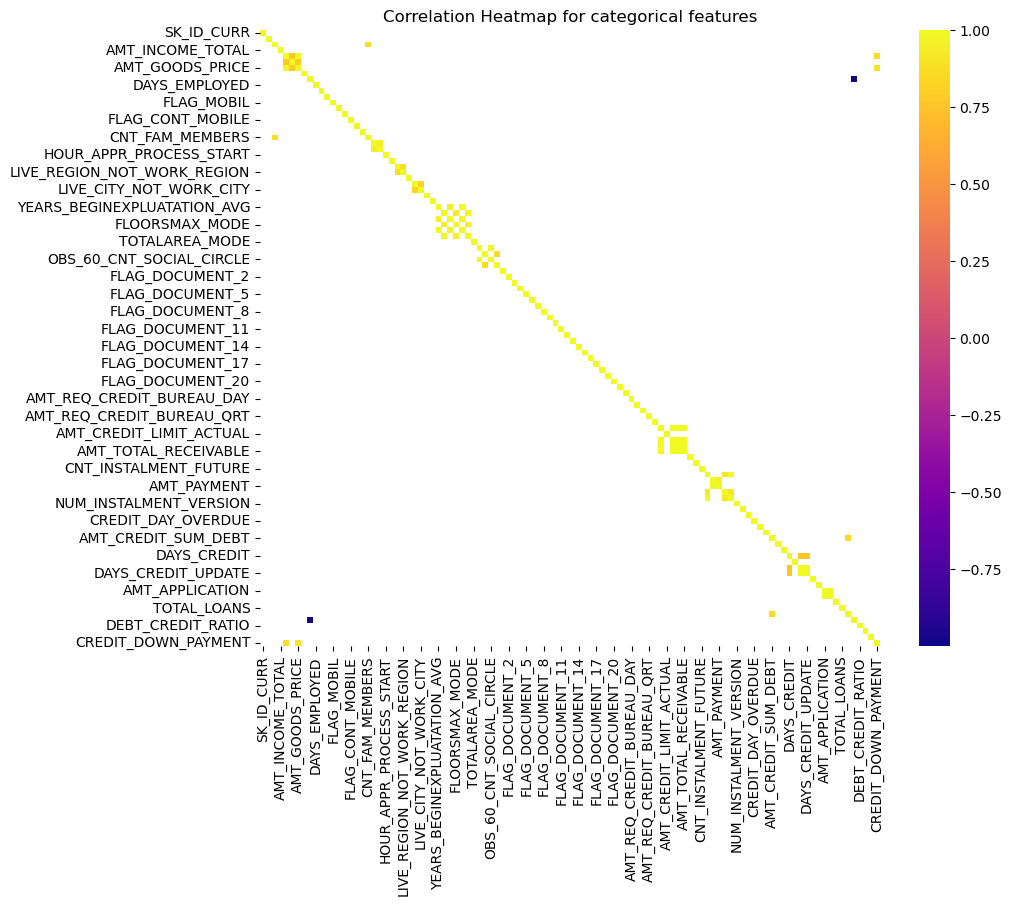

In [31]:
plt.figure(figsize=(10,8))
sns.heatmap((train.corr(numeric_only=True)[(train.corr(numeric_only=True) >= 0.7) | (train.corr(numeric_only=True) <= -0.7)]), cmap='plasma', annot=False, annot_kws={'size': 2, 'color':'black'})
plt.title('Correlation Heatmap for categorical features')
plt.show()

In [32]:
# train = train[[
#     #TRAIN
#     'SK_ID_CURR',
#     'TARGET',
#     'NAME_CONTRACT_TYPE',
#     'CODE_GENDER',
#     'FLAG_OWN_REALTY',
#     'NAME_INCOME_TYPE',
#     'EXT_SOURCE_2',
#     'EXT_SOURCE_3',
#     # 'DAYS_BIRTH',
#     'REGION_RATING_CLIENT_W_CITY',
#     'DAYS_LAST_PHONE_CHANGE',
#     'DAYS_ID_PUBLISH',
#     'REG_CITY_NOT_WORK_CITY',
    
    
#     #CREDIT CARD BALANCE
#     'AMT_BALANCE',
#     # 'AMT_CREDIT_LIMIT_ACTUAL',
#     # 'AMT_RECEIVABLE_PRINCIPAL',
#     # 'AMT_RECIVABLE',
#     'AMT_TOTAL_RECEIVABLE',
#     'CNT_INSTALMENT_MATURE_CUM',

#     #POS CASH BALANCE
#     'NAME_CONTRACT_STATUS',
#     'CNT_INSTALMENT',
#     'CNT_INSTALMENT_FUTURE',
    
#     #BUREAU
#     'CREDIT_ACTIVE',
#     'CREDIT_TYPE',
#     'CNT_CREDIT_PROLONG',
#     'CREDIT_DAY_OVERDUE',
#     'AMT_CREDIT_MAX_OVERDUE',
#     # 'AMT_CREDIT_SUM',
#     # 'AMT_CREDIT_SUM_DEBT',
#     'AMT_CREDIT_SUM_LIMIT',
#     'AMT_CREDIT_SUM_OVERDUE',

#     #PREVIOUS APPLICATION
#     'AMT_DOWN_PAYMENT',
#     'CODE_REJECT_REASON',
#     'NAME_YIELD_GROUP',
#     'PRODUCT_COMBINATION',
#     'AMT_APPLICATION',
#     # 'AMT_CREDIT',
#     'CNT_PAYMENT',

#     #ADDED FEATS
#     'REGION_POPULATION_RELATIVE',

#     #FEAT USED TO ENGINEER
#     'AMT_ANNUITY',

#     #FEAT ENGINEERING
#     'DTI',
#     'AGE',
#     'DEBT_CREDIT_RATIO',
#     'CREDIT_ANNUITY_RATIO'
# ]]
# train.info()

In [33]:
train = train[[
    'SK_ID_CURR',
    'TARGET',

    #CATEGORICAL
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'NAME_TYPE_SUITE',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE',
    'WEEKDAY_APPR_PROCESS_START',
    'ORGANIZATION_TYPE',
    'EMERGENCYSTATE_MODE',
    'NAME_CONTRACT_STATUS',
    'CREDIT_ACTIVE',
    'CREDIT_TYPE',
    'CODE_REJECT_REASON',
    'NAME_YIELD_GROUP',
    'PRODUCT_COMBINATION',
    

    

    #CONTINUOUS
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'AMT_BALANCE',
    'AMT_TOTAL_RECEIVABLE',
    'AMT_RECIVABLE',
    'AMT_RECEIVABLE_PRINCIPAL',
    'DAYS_BIRTH',
    'REGION_RATING_CLIENT_W_CITY',
    'REGION_RATING_CLIENT',
    'DAYS_LAST_PHONE_CHANGE',
    'DAYS_ID_PUBLISH',
    'REG_CITY_NOT_WORK_CITY',
    'FLAG_EMP_PHONE',
    'DAYS_EMPLOYED',
    'REG_CITY_NOT_LIVE_CITY',
    'FLAG_DOCUMENT_3',
    'DAYS_REGISTRATION',
    'CNT_INSTALMENT_MATURE_CUM',
    'AMT_GOODS_PRICE',
    'FLOORSMAX_MODE',
    'REGION_POPULATION_RELATIVE',
    'LIVE_CITY_NOT_WORK_CITY',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE',
    'AMT_CREDIT_x',
    'TOTALAREA_MODE',
    'FLOORSMAX_AVG',
    'FLOORSMAX_MEDI',
    'FLAG_DOCUMENT_6',
    'FLAG_WORK_PHONE',
    'AMT_DOWN_PAYMENT',
    'HOUR_APPR_PROCESS_START',
    'FLAG_PHONE',
    'AMT_APPLICATION',
    'AMT_CREDIT_SUM',
    'CNT_CHILDREN',
    'AMT_CREDIT_y',
    'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_ANNUITY_x',
    'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_13',
    'AMT_CREDIT_SUM_LIMIT',
    'DAYS_CREDIT',
    'NUM_INSTALMENT_NUMBER',

    # 'DAYS_CREDIT_ENDDATE',
    # 'DAYS_ENDDATE_FACT',
    # 'DAYS_CREDIT_UPDATE',
    # 'AMT_ANNUITY_y',
    'DAYS_ENTRY_PAYMENT',
    'AMT_PAYMENT',
    'DAYS_INSTALMENT',

    #FEAT ENGINEERED
    'AGE',
    'DTI',
    'DEBT_CREDIT_RATIO',
    'CREDIT_ANNUITY_RATIO',
    'CREDIT_GOODS_PRICE_RATIO',
    'CREDIT_DOWN_PAYMENT',
    # 'INSTALLMENT_PAYMENT_RATIO'
    # 'TOTAL_LOANS'
]]

## Encoding/Scaling

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int64  
 1   TARGET                       307511 non-null  int64  
 2   NAME_CONTRACT_TYPE           307511 non-null  object 
 3   CODE_GENDER                  307511 non-null  object 
 4   FLAG_OWN_CAR                 307511 non-null  object 
 5   FLAG_OWN_REALTY              307511 non-null  object 
 6   NAME_TYPE_SUITE              307511 non-null  object 
 7   NAME_INCOME_TYPE             307511 non-null  object 
 8   NAME_EDUCATION_TYPE          307511 non-null  object 
 9   NAME_FAMILY_STATUS           307511 non-null  object 
 10  NAME_HOUSING_TYPE            307511 non-null  object 
 11  OCCUPATION_TYPE              307511 non-null  object 
 12  WEEKDAY_APPR_PROCESS_START   307511 non-null  object 
 13 

In [35]:
# ord_feats_edit = [
#     'FLAG_OWN_REALTY',
#     'EXT_SOURCE_2',#
#     'EXT_SOURCE_3',
#     'AGE',
#     'REGION_RATING_CLIENT_W_CITY',
#     'CREDIT_DAY_OVERDUE',#
#     'AMT_CREDIT_SUM_OVERDUE',#
#     'NAME_YIELD_GROUP',
#     'DTI'

#     # 'FLAG_OWN_REALTY',
#     # 'REGION_RATING_CLIENT_W_CITY',
#     # 'AMT_CREDIT_LIMIT_ACTUAL',
#     # 'NAME_YIELD_GROUP',
#     # 'PRODUCT_COMBINATION'
# ]

ord_feats_edit = [
  'CREDIT_TYPE',
  'NAME_YIELD_GROUP',
  'REGION_RATING_CLIENT_W_CITY',
  'REGION_RATING_CLIENT',
  'AGE',
  'DTI'
]

ord_feats = train[ord_feats_edit]
ord = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
ord.fit(ord_feats)
ord_feats_encoded = ord.transform(ord_feats)
new_ord_feats = pd.DataFrame(ord_feats_encoded, columns=ord_feats.columns)
new_ord_feats




,CREDIT_TYPE,NAME_YIELD_GROUP,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,AGE,DTI
0,2.0,3.0,1.0,1.0,5.0,69.0
1,2.0,4.0,0.0,0.0,25.0,32.0
2,2.0,4.0,1.0,1.0,32.0,32.0
3,NaN,0.0,1.0,1.0,32.0,NaN
4,2.0,1.0,1.0,1.0,34.0,32.0
...,...,...,...,...,...,...
307506,NaN,1.0,0.0,0.0,5.0,NaN
307507,NaN,3.0,1.0,1.0,36.0,NaN
307508,2.0,1.0,2.0,2.0,21.0,325.0
307509,2.0,1.0,1.0,1.0,12.0,32.0


In [36]:
train.drop(columns=ord_feats, inplace=True)
train = train.merge(new_ord_feats, left_index=True, right_index=True)
train

C:\Users\rvuon\AppData\Local\Temp\ipykernel_41616\3098617036.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(columns=ord_feats, inplace=True)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,EMERGENCYSTATE_MODE,NAME_CONTRACT_STATUS,CREDIT_ACTIVE,CODE_REJECT_REASON,PRODUCT_COMBINATION,EXT_SOURCE_2,EXT_SOURCE_3,AMT_BALANCE,AMT_TOTAL_RECEIVABLE,AMT_RECIVABLE,AMT_RECEIVABLE_PRINCIPAL,DAYS_BIRTH,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,FLAG_EMP_PHONE,DAYS_EMPLOYED,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,DAYS_REGISTRATION,CNT_INSTALMENT_MATURE_CUM,AMT_GOODS_PRICE,FLOORSMAX_MODE,REGION_POPULATION_RELATIVE,LIVE_CITY_NOT_WORK_CITY,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,AMT_CREDIT_x,TOTALAREA_MODE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLAG_DOCUMENT_6,FLAG_WORK_PHONE,AMT_DOWN_PAYMENT,HOUR_APPR_PROCESS_START,FLAG_PHONE,AMT_APPLICATION,AMT_CREDIT_SUM,CNT_CHILDREN,AMT_CREDIT_y,AMT_REQ_CREDIT_BUREAU_MON,AMT_ANNUITY_x,FLAG_DOCUMENT_16,FLAG_DOCUMENT_13,AMT_CREDIT_SUM_LIMIT,DAYS_CREDIT,NUM_INSTALMENT_NUMBER,DAYS_ENTRY_PAYMENT,AMT_PAYMENT,DAYS_INSTALMENT,DEBT_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_PRICE_RATIO,CREDIT_DOWN_PAYMENT,CREDIT_TYPE,NAME_YIELD_GROUP,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,AGE,DTI
0,100002,1,Cash loans,M,N,Y,Unaccompanied,Working,Secondary,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,No,Active,Closed,XAP,POS other with interest,0.262949,0.139376,NaN,NaN,NaN,NaN,-9461,-1134.0,-2120,0,1,-637,0,1,-3648.0,NaN,351000.0,0.0833,0.018801,0,2.0,2.0,406597.5,0.0149,0.083300,0.083300,0,0,0.000000,10,1,179055.000,108131.945625,0,179055.00,0.0,24700.5,0,0,6397.713,-874.000000,1.0,-315.421053,11559.247105,-295.000000,0.701703,16.461104,1.158397,171945.00,2.0,3.0,1.0,1.0,5.0,69.0
1,100003,0,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,No,Active,Closed,XAP,Cash X-Sell: low,0.622246,0.510853,NaN,NaN,NaN,NaN,-16765,-828.0,-291,0,1,-1188,0,1,-1186.0,NaN,1129500.0,0.2917,0.003541,0,0.0,0.0,1293502.5,0.0149,0.291700,0.291700,0,0,2295.000000,11,1,435436.500,254350.125000,0,484191.00,0.0,35698.5,0,0,202500.000,-1400.750000,1.0,-1385.320000,64754.586000,-1378.160000,0.000000,36.234085,1.145199,645309.00,2.0,4.0,0.0,0.0,25.0,32.0
2,100004,0,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary,Single / not married,House / apartment,Laborers,MONDAY,Government,No,Active,Closed,XAP,POS mobile without interest,0.555912,0.729567,NaN,NaN,NaN,NaN,-19046,-815.0,-2531,0,1,-225,0,0,-4260.0,NaN,135000.0,0.1667,0.010032,0,0.0,0.0,135000.0,0.0149,0.226282,0.225897,0,1,4860.000000,9,1,24282.000,94518.900000,0,20106.00,0.0,6750.0,0,0,0.000,-867.000000,1.0,-761.666667,7096.155000,-754.000000,0.000000,20.000000,1.000000,114894.00,2.0,4.0,1.0,1.0,32.0,32.0
3,100006,0,Cash loans,F,N,Y,Unaccompanied,Working,Secondary,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,No,Active,NaN,XAP,Cash,0.650442,0.510853,0.0,0.0,0.0,0.0,-19005,-617.0,-2437,0,1,-3039,0,1,-9833.0,0.0,297000.0,0.1667,0.008019,0,0.0,0.0,312682.5,0.0149,0.226282,0.225897,0,0,8466.887198,17,0,272203.260,NaN,0,291695.50,0.0,29686.5,0,0,NaN,NaN,1.0,-271.625000,62947.088438,-252.250000,NaN,10.532818,1.052803,5304.50,NaN,0.0,1.0,1.0,32.0,NaN
4,100007,0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary,Single / not married,House / apartment,Laborers,THURSDAY,Religion,No,Active,Closed,XAP,Cash X-Sell: middle,0.322738,0.510853,NaN,NaN,NaN,NaN,-19932,-1106.0,-3458,1,1,-3038,0,0,-4311.0,NaN,513000.0,0.1667,0.028663,1,0.0,0.0,513000.0,0.0149,0.226282,0.225897,0,0,1130.250000,11,0,150530.250,146250.000000,0,166638.75,0.0,21865.5,0,0,0.000,-1149.000000,1.0,-1032.242424,12214.060227,-1028.606061,0.000000,23.461618,1.000000,346361.25,2.0,1.0,1.0,1.0,34.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [37]:
# nom_feats_edit = [

#     'NAME_CONTRACT_TYPE',
#     'CODE_GENDER',
#     'NAME_INCOME_TYPE',
#     'DAYS_LAST_PHONE_CHANGE',
#     'DAYS_ID_PUBLISH',
#     'REG_CITY_NOT_WORK_CITY',
#     'NAME_CONTRACT_STATUS',
#     'CREDIT_ACTIVE',
#     'CREDIT_TYPE',
#     'CNT_CREDIT_PROLONG',
#     'CODE_REJECT_REASON',
#     'PRODUCT_COMBINATION',
#     'CNT_PAYMENT',
#     'AGE',
#     'REGION_POPULATION_RELATIVE'

#     # 'NAME_CONTRACT_TYPE',
#     # 'CODE_GENDER',
#     # 'NAME_INCOME_TYPE',
#     # 'DAYS_BIRTH',
#     # 'REG_CITY_NOT_WORK_CITY',
#     # 'CNT_INSTALMENT_MATURE_CUM',#
#     # 'NAME_CONTRACT_STATUS',
#     # 'CNT_INSTALMENT',#
#     # 'CNT_INSTALMENT_FUTURE',#
#     # 'CREDIT_ACTIVE',
#     # 'CREDIT_TYPE',
#     # 'CNT_CREDIT_PROLONG',
#     # 'CODE_REJECT_REASON',
#     # 'CNT_PAYMENT'
# ]

nom_feats_edit = [
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'NAME_TYPE_SUITE',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE',
    'WEEKDAY_APPR_PROCESS_START',
    'ORGANIZATION_TYPE',
    'EMERGENCYSTATE_MODE',
    'NAME_CONTRACT_STATUS',
    'CREDIT_ACTIVE',
    'CODE_REJECT_REASON',
    'PRODUCT_COMBINATION',
    'REG_CITY_NOT_WORK_CITY',
    'FLAG_EMP_PHONE',
    'DAYS_EMPLOYED',
    'REG_CITY_NOT_LIVE_CITY',
    'FLAG_DOCUMENT_3',
    'FLOORSMAX_MODE',
    'REGION_POPULATION_RELATIVE',
    'LIVE_CITY_NOT_WORK_CITY',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE',
    'TOTALAREA_MODE',
    'FLOORSMAX_AVG',
    'FLOORSMAX_MEDI',
    'FLAG_DOCUMENT_6',
    'FLAG_WORK_PHONE',
    'HOUR_APPR_PROCESS_START',
    'FLAG_PHONE',
    'AMT_REQ_CREDIT_BUREAU_MON',
    'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_13',
    'CREDIT_GOODS_PRICE_RATIO',

    'CREDIT_DOWN_PAYMENT',
    # 'INSTALLMENT_PAYMENT_RATIO'
    'NUM_INSTALMENT_NUMBER'



]

nom_feats = train[nom_feats_edit]
ce = ce.OneHotEncoder(use_cat_names=True)
ce.fit(nom_feats)
nom_feats_encoded = ce.transform(nom_feats)
nom_feats_encoded



,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_F,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,FLAG_OWN_REALTY_N,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Other_A,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Maternity leave,NAME_EDUCATION_TYPE_Secondary,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Academic degree,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Unknown,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Co-op apartment,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Sales staff,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Housing,...,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Signed,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_nan,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Sold,CREDIT_ACTIVE_nan,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_XNA,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_nan,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan,REG_CITY_NOT_WORK_CITY,FLAG_EMP_PHONE,DAYS_EMPLOYED,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,FLOORSMAX_MODE,REGION_POPULATION_RELATIVE,LIVE_CITY_NOT_WORK_CITY,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,TOTALAREA_MODE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLAG_DOCUMENT_6,FLAG_WORK_PHONE,HOUR_APPR_PROCESS_START,FLAG_PHONE,AMT_REQ_CREDIT_BUREAU_MON,FLAG_DOCUMENT_16,FLAG_DOCUMENT_13,CREDIT_GOODS_PRICE_RATIO,CREDIT_DOWN_PAYMENT,NUM_INSTALMENT_NUMBER
0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-637,0,1,0.0833,0.018801,0,2.0,2.0,0.0149,0.083300,0.083300,0,0,10,1,0.0,0,0,1.158397,171945.00,1.0
1,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1188,0,1,0.2917,0.003541,0,0.0,0.0,0.0149,0.291700,0.291700,0,0,11,1,0

In [38]:
train.drop(columns=nom_feats, inplace=True)
train = train.merge(nom_feats_encoded, left_index=True, right_index=True)
train

,SK_ID_CURR,TARGET,EXT_SOURCE_2,EXT_SOURCE_3,AMT_BALANCE,AMT_TOTAL_RECEIVABLE,AMT_RECIVABLE,AMT_RECEIVABLE_PRINCIPAL,DAYS_BIRTH,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,DAYS_REGISTRATION,CNT_INSTALMENT_MATURE_CUM,AMT_GOODS_PRICE,AMT_CREDIT_x,AMT_DOWN_PAYMENT,AMT_APPLICATION,AMT_CREDIT_SUM,CNT_CHILDREN,AMT_CREDIT_y,AMT_ANNUITY_x,AMT_CREDIT_SUM_LIMIT,DAYS_CREDIT,DAYS_ENTRY_PAYMENT,AMT_PAYMENT,DAYS_INSTALMENT,DEBT_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,CREDIT_TYPE,NAME_YIELD_GROUP,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,AGE,DTI,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_F,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,FLAG_OWN_REALTY_N,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Other_A,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Maternity leave,NAME_EDUCATION_TYPE_Secondary,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Academic degree,NAME_FAMILY_STATUS_Single / not married,...,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Signed,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_nan,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Sold,CREDIT_ACTIVE_nan,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_XNA,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_nan,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan,REG_CITY_NOT_WORK_CITY,FLAG_EMP_PHONE,DAYS_EMPLOYED,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,FLOORSMAX_MODE,REGION_POPULATION_RELATIVE,LIVE_CITY_NOT_WORK_CITY,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,TOTALAREA_MODE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLAG_DOCUMENT_6,FLAG_WORK_PHONE,HOUR_APPR_PROCESS_START,FLAG_PHONE,AMT_REQ_CREDIT_BUREAU_MON,FLAG_DOCUMENT_16,FLAG_DOCUMENT_13,CREDIT_GOODS_PRICE_RATIO,CREDIT_DOWN_PAYMENT,NUM_INSTALMENT_NUMBER
0,100002,1,0.262949,0.139376,NaN,NaN,NaN,NaN,-9461,-1134.0,-2120,-3648.0,NaN,351000.0,406597.5,0.000000,179055.000,108131.945625,0,179055.00,24700.5,6397.713,-874.000000,-315.421053,11559.247105,-295.000000,0.701703,16.461104,2.0,3.0,1.0,1.0,5.0,69.0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-637,0,1,0.0833,0.018801,0,2.0,2.0,0.0149,0.083300,0.083300,0,0,10,1,0.0,0,0,1.158397,171945.00,1.0
1,100003,0,0.622246,0.510853,NaN,NaN,NaN,NaN,-16765,-828.0,-291,-1186.0,NaN,1129500.0,1293502.5,2295.000000,435436.500,254350.125000,0,484191.00,35698.5,202500.000,-1400.750000,-1385.320000,64754.586000,-1378.160000,0.000000,36.234085,2.0,4.0,0.0,0.0,25.0,32.0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1188,0,1,0.2917,0.003541,0,0.0,0.0,0.0149,0.291700,0.291700,0,0,11,1,0.0,0,0,1.145199,645309.00,1.0
2,100004,0,0.555912,0.729567,NaN,NaN,NaN,NaN,-19046,-815.0,-2531,-4260.0,NaN,135000.0,135000.0,4860.000000,24282.000,94518.900000,0,20

In [39]:
train['AMT_CREDIT_SUM_LIMIT'].value_counts()

AMT_CREDIT_SUM_LIMIT
0.000000        214639
22500.000000       449
45000.000000       321
11250.000000       290
33750.000000       224
                 ...  
39375.433125         1
90636.968571         1
1217.815714          1
360.378000           1
44.553750            1
Name: count, Length: 39089, dtype: int64

In [40]:
# cont_feats_edit = [

#     'AMT_BALANCE',
#     'AMT_TOTAL_RECEIVABLE',
#     'CNT_INSTALMENT_MATURE_CUM',
#     'CNT_INSTALMENT',
#     'CNT_INSTALMENT_FUTURE',
#     'AMT_CREDIT_MAX_OVERDUE',
#     # 'AMT_CREDIT_SUM',
#     'AMT_CREDIT_SUM_LIMIT',
#     'AMT_DOWN_PAYMENT',
#     'AMT_APPLICATION',

#     #FEAT ENGINEERING
#     'DEBT_CREDIT_RATIO',
#     'CREDIT_ANNUITY_RATIO'
    

#     # 'EXT_SOURCE_2',
#     # 'EXT_SOURCE_3',
#     # 'DAYS_LAST_PHONE_CHANGE',
#     # 'DAYS_ID_PUBLISH',
#     # 'AMT_BALANCE',
#     # 'AMT_RECEIVABLE_PRINCIPAL',
#     # 'AMT_RECIVABLE',
#     # 'AMT_TOTAL_RECEIVABLE',
#     # 'CREDIT_DAY_OVERDUE',#
#     # 'AMT_CREDIT_MAX_OVERDUE',
#     # 'AMT_CREDIT_SUM',
#     # 'AMT_CREDIT_SUM_DEBT',
#     # 'AMT_CREDIT_SUM_LIMIT',
#     # 'AMT_CREDIT_SUM_OVERDUE',
#     # 'AMT_DOWN_PAYMENT',
#     # 'AMT_APPLICATION',
#     # 'AMT_CREDIT',

#     # 'DTI'

# ]

cont_feats_edit = [
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'AMT_BALANCE',
    'AMT_TOTAL_RECEIVABLE',
    'AMT_RECIVABLE',
    'AMT_RECEIVABLE_PRINCIPAL',
    'DAYS_BIRTH',
    'DAYS_LAST_PHONE_CHANGE',
    'DAYS_ID_PUBLISH',
    'DAYS_REGISTRATION',
    'CNT_INSTALMENT_MATURE_CUM',
    'AMT_GOODS_PRICE',
    'AMT_CREDIT_x',
    'AMT_DOWN_PAYMENT',
    'AMT_APPLICATION',
    'AMT_CREDIT_SUM',
    'CNT_CHILDREN',
    'AMT_ANNUITY_x',
    'AMT_CREDIT_SUM_LIMIT',
    'DEBT_CREDIT_RATIO',
    'CREDIT_ANNUITY_RATIO',
    'DAYS_CREDIT',
    # 'TOTAL_LOANS'
    'DAYS_ENTRY_PAYMENT',
    'AMT_PAYMENT',
    'DAYS_INSTALMENT'



]
cont_feats = train[cont_feats_edit]
min = MinMaxScaler()
min.fit(cont_feats)
cont_feats_scaled = min.transform(cont_feats)
new_cont_feats = pd.DataFrame(cont_feats_scaled, columns=cont_feats.columns)
new_cont_feats

,EXT_SOURCE_2,EXT_SOURCE_3,AMT_BALANCE,AMT_TOTAL_RECEIVABLE,AMT_RECIVABLE,AMT_RECEIVABLE_PRINCIPAL,DAYS_BIRTH,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,DAYS_REGISTRATION,CNT_INSTALMENT_MATURE_CUM,AMT_GOODS_PRICE,AMT_CREDIT_x,AMT_DOWN_PAYMENT,AMT_APPLICATION,AMT_CREDIT_SUM,CNT_CHILDREN,AMT_ANNUITY_x,AMT_CREDIT_SUM_LIMIT,DEBT_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,DAYS_CREDIT,DAYS_ENTRY_PAYMENT,AMT_PAYMENT,DAYS_INSTALMENT
0,0.307542,0.155054,NaN,NaN,NaN,NaN,0.888839,0.735788,0.705433,0.852140,NaN,0.077441,0.090287,0.000000,0.044211,0.000546,0.0,0.090032,0.046654,0.961288,0.217795,0.700890,0.898168,0.004615,0.899966
1,0.727773,0.569889,NaN,NaN,NaN,NaN,0.477114,0.807083,0.959566,0.951929,NaN,0.271605,0.311736,0.001159,0.107515,0.001284,0.0,0.132924,0.134380,0.957455,0.622113,0.520619,0.549439,0.025854,0.528893
2,0.650190,0.814130,NaN,NaN,NaN,NaN,0.348534,0.810112,0.648326,0.827335,NaN,0.023569,0.022472,0.002455,0.005996,0.000477,0.0,0.020025,0.043792,0.957455,0.290158,0.703285,0.752716,0.002833,0.742720
3,0.760751,0.569889,0.003145,0.003199,0.003199,0.003302,0.350846,0.856244,0.661387,0.601451,0.0,0.063973,0.066837,0.004276,0.067211,NaN,0.0,0.109477,NaN,NaN,0.096573,NaN,0.912443,0.025133,0.914611
4,0.377472,0.569889,NaN,NaN,NaN,NaN,0.298591,0.742311,0.519522,0.825268,NaN,0.117845,0.116854,0.000571,0.037168,0.000738,0.0,0.078975,0.043792,0.957455,0.360941,0.606776,0.664523,0.004877,0.648645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.797231,0.569889,NaN,NaN,NaN,NaN,0.896392,0.936393,0.724607,0.657263,NaN,0.046016,0.052360,0.000000,0.009989,NaN,0.0,0.101176,NaN,NaN,0.070185,NaN,0.950037,0.002992,0.959918
307507,0.135663,0.569889,NaN,NaN,NaN,NaN,0.251071,1.000000,0.431708,0.822147,NaN,0.046016,0.056067,0.001745,0.014221,NaN,0.0,0.040505,NaN,NaN,0.340454,NaN,0.220719,0.004020,0.181912
307508,0.626575,0.243815,NaN,NaN,NaN,NaN,0.578523,0.555219,0.284424,0.726937,NaN,0.135802,0.157969,0.002224,0.005966,0.004998,0.0,0.110618,0.043792,0.959932,0.343417,0.703114,0.222807,0.001643,0.188103
307509,0.601360,0.737587,NaN,NaN,NaN,NaN,0.747914,0.924977,0.870641,0.896158,NaN,0.069585,0.081175,0.000000,0.029955,0.000227,0.0,0.072499,0.043792,0.957455,0.255756,0.622177,0.948415,0.004088,0.952291


In [41]:
train.drop(columns=cont_feats, inplace=True)
train = train.merge(new_cont_feats, left_index=True, right_index=True)
train

,SK_ID_CURR,TARGET,AMT_CREDIT_y,CREDIT_TYPE,NAME_YIELD_GROUP,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,AGE,DTI,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_F,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,FLAG_OWN_REALTY_N,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Other_A,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Maternity leave,NAME_EDUCATION_TYPE_Secondary,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Academic degree,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Unknown,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Co-op apartment,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Sales staff,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Religion,...,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan,REG_CITY_NOT_WORK_CITY,FLAG_EMP_PHONE,DAYS_EMPLOYED,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,FLOORSMAX_MODE,REGION_POPULATION_RELATIVE,LIVE_CITY_NOT_WORK_CITY,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,TOTALAREA_MODE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLAG_DOCUMENT_6,FLAG_WORK_PHONE,HOUR_APPR_PROCESS_START,FLAG_PHONE,AMT_REQ_CREDIT_BUREAU_MON,FLAG_DOCUMENT_16,FLAG_DOCUMENT_13,CREDIT_GOODS_PRICE_RATIO,CREDIT_DOWN_PAYMENT,NUM_INSTALMENT_NUMBER,EXT_SOURCE_2,EXT_SOURCE_3,AMT_BALANCE,AMT_TOTAL_RECEIVABLE,AMT_RECIVABLE,AMT_RECEIVABLE_PRINCIPAL,DAYS_BIRTH,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,DAYS_REGISTRATION,CNT_INSTALMENT_MATURE_CUM,AMT_GOODS_PRICE,AMT_CREDIT_x,AMT_DOWN_PAYMENT,AMT_APPLICATION,AMT_CREDIT_SUM,CNT_CHILDREN,AMT_ANNUITY_x,AMT_CREDIT_SUM_LIMIT,DEBT_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,DAYS_CREDIT,DAYS_ENTRY_PAYMENT,AMT_PAYMENT,DAYS_INSTALMENT
0,100002,1,179055.00,2.0,3.0,1.0,1.0,5.0,69.0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-637,0,1,0.0833,0.018801,0,2.0,2.0,0.0149,0.083300,0.083300,0,0,10,1,0.0,0,0,1.158397,171945.00,1.0,0.307542,0.155054,NaN,NaN,NaN,NaN,0.888839,0.735788,0.705433,0.852140,NaN,0.077441,0.090287,0.000000,0.044211,0.000546,0.0,0.090032,0.046654,0.961288,0.217795,0.700890,0.898168,0.004615,0.899966
1,100003,0,484191.00,2.0,4.0,0.0,0.0,25.0,32.0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1188,0,1,0.2917,0.003541,0,0.0,0.0,0.0149,0.291700,0.291700,0,0,11,1,0.0,0,0,1.145199,645309.00,1.0,0.727773,0.569889,NaN,NaN,NaN,NaN,0.477114,0.807083,0.959566,0.951929,NaN,0.271605,0.311736,0.001159,0.107515,0.001284,0.0,0.132924,0.134380,0.957455,0.622113,0.520619,0.549439,0.025854,0.528893
2,100004,0,20106.00,2.0,4.0,1.0,1.0,32.0,32.0,0,1,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,

## Train Test Split

In [42]:
x = train.drop(columns=['SK_ID_CURR', 'TARGET'], axis=1)
x

,AMT_CREDIT_y,CREDIT_TYPE,NAME_YIELD_GROUP,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,AGE,DTI,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_F,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,FLAG_OWN_REALTY_N,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Other_A,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Maternity leave,NAME_EDUCATION_TYPE_Secondary,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Academic degree,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Unknown,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Co-op apartment,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Sales staff,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_XNA,...,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan,REG_CITY_NOT_WORK_CITY,FLAG_EMP_PHONE,DAYS_EMPLOYED,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,FLOORSMAX_MODE,REGION_POPULATION_RELATIVE,LIVE_CITY_NOT_WORK_CITY,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,TOTALAREA_MODE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLAG_DOCUMENT_6,FLAG_WORK_PHONE,HOUR_APPR_PROCESS_START,FLAG_PHONE,AMT_REQ_CREDIT_BUREAU_MON,FLAG_DOCUMENT_16,FLAG_DOCUMENT_13,CREDIT_GOODS_PRICE_RATIO,CREDIT_DOWN_PAYMENT,NUM_INSTALMENT_NUMBER,EXT_SOURCE_2,EXT_SOURCE_3,AMT_BALANCE,AMT_TOTAL_RECEIVABLE,AMT_RECIVABLE,AMT_RECEIVABLE_PRINCIPAL,DAYS_BIRTH,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,DAYS_REGISTRATION,CNT_INSTALMENT_MATURE_CUM,AMT_GOODS_PRICE,AMT_CREDIT_x,AMT_DOWN_PAYMENT,AMT_APPLICATION,AMT_CREDIT_SUM,CNT_CHILDREN,AMT_ANNUITY_x,AMT_CREDIT_SUM_LIMIT,DEBT_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,DAYS_CREDIT,DAYS_ENTRY_PAYMENT,AMT_PAYMENT,DAYS_INSTALMENT
0,179055.00,2.0,3.0,1.0,1.0,5.0,69.0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-637,0,1,0.0833,0.018801,0,2.0,2.0,0.0149,0.083300,0.083300,0,0,10,1,0.0,0,0,1.158397,171945.00,1.0,0.307542,0.155054,NaN,NaN,NaN,NaN,0.888839,0.735788,0.705433,0.852140,NaN,0.077441,0.090287,0.000000,0.044211,0.000546,0.0,0.090032,0.046654,0.961288,0.217795,0.700890,0.898168,0.004615,0.899966
1,484191.00,2.0,4.0,0.0,0.0,25.0,32.0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1188,0,1,0.2917,0.003541,0,0.0,0.0,0.0149,0.291700,0.291700,0,0,11,1,0.0,0,0,1.145199,645309.00,1.0,0.727773,0.569889,NaN,NaN,NaN,NaN,0.477114,0.807083,0.959566,0.951929,NaN,0.271605,0.311736,0.001159,0.107515,0.001284,0.0,0.132924,0.134380,0.957455,0.622113,0.520619,0.549439,0.025854,0.528893
2,20106.00,2.0,4.0,1.0,1.0,32.0,32.0,0,1,1,0,0,0,1,1,0,1,0,0,1

In [43]:
y = train['TARGET']
y

0         1
1         0
2         0
3         0
4         0
         ..
307506    0
307507    0
307508    0
307509    1
307510    0
Name: TARGET, Length: 307511, dtype: int64

## Undersampling

In [44]:
rus = RandomUnderSampler()
X_rus, Y_rus = rus.fit_resample(x,y)
X_rus.shape, Y_rus.shape

((49650, 202), (49650,))

In [45]:
xtrain, xtest, ytrain, ytest = train_test_split(X_rus, Y_rus, random_state=0, stratify=Y_rus)
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((37237, 202), (37237,), (12413, 202), (12413,))

## Training

### Cross Validation

In [46]:
# param_grid = {
#     'max_depth': [2,3,4],
#     'min_child_weight': [4,5,6],
#     'gamma': [0.05, 0.1, 0.15],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'n_estimators': [250, 300, 400],
#     'reg_alpha': [ 0.9, 0.92, .95],
#     'reg_lambda': [.7, .75, .79]
# }

In [47]:
# xgb = XGBClassifier(random_state=0, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=300, reg_alpha=.93, reg_lambda=0.74)
# xgb_model = xgb.fit(xtrain, ytrain)
# xgb_pred = xgb_model.predict(xtest)

In [48]:
# grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=5)
# grid_search.fit(xtrain, ytrain)
# best_params = grid_search.best_params_
# print('Best Parameters: ', best_params)

Best Parameters:  {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 300}

In [49]:
# best_model = grid_search.best_estimator_
# accuracy = best_model.score(xtest, ytest)
# print('Accuracy with best parameters: ', accuracy)

In [50]:
param_grid = {
    'max_depth': [32,33,34],
    'n_estimators': [610, 625, 640],
    'min_samples_split': [10,11,12],
    'min_samples_leaf': [0.75, 1, 1.25]
}

SyntaxError: invalid syntax (1692829007.py, line 4)

In [ ]:
rf = RandomForestClassifier(random_state=0, max_depth=33, min_samples_leaf=1, min_samples_split=11, n_estimators=610)
rf_model = rf.fit(xtrain, ytrain)
rf_pred = rf_model.predict(xtest)


In [ ]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(xtrain, ytrain)
best_params = grid_search.best_params_
print('Best Parameters: ', best_params)

c:\Users\rvuon\miniforge3\envs\learn\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
135 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rvuon\miniforge3\envs\learn\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\rvuon\miniforge3\envs\learn\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\rvuon\miniforge3\envs\learn\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(


Best Parameters:  {'max_depth': 33, 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 610}


Best Parameters:  {'max_depth': 33, 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 610}
Best Parameters:  {'max_depth': 33, 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 580}
Best Parameters:  {'max_depth': 33, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 565}
Best Parameters:  {'max_depth': 34, 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 565}
Best Parameters:  {'max_depth': 34, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 565}
Best Parameters:  {'max_depth': 36, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 580}
Best Parameters:  {'max_depth': 38, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 580}
Best Parameters:  {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 17, 'n_estimators': 550}
Best Parameters:  {'max_depth': 39, 'min_samples_leaf': 1, 'min_samples_split': 16, 'n_estimators': 565}
Best Parameters:  {'max_depth': 38, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 505}
Best Parameters:  {'max_depth': 38, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 490}
Best Parameters:  {'max_depth': 39, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 490}
Best Parameters:  {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 16, 'n_estimators': 490}
Best Parameters:  {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 475}
Best Parameters:  {'max_depth': 39, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 490}
Best Parameters:  {'max_depth': 39, 'min_samples_leaf': 1, 'min_samples_split': 16, 'n_estimators': 460}
Best Parameters:  {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 460}
Best Parameters:  {'max_depth': 41, 'min_samples_leaf': 1, 'min_samples_split': 16, 'n_estimators': 490}
Best Parameters:  {'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 18, 'n_estimators': 525}
Best Parameters:  {'max_depth': 39, 'min_samples_leaf': 1, 'min_samples_split': 18, 'n_estimators': 540}
Best Parameters:  {'max_depth': 38, 'min_samples_leaf': 1, 'min_samples_split': 17, 'n_estimators': 525}
Best Parameters:  {'max_depth': 38, 'min_samples_leaf': 1, 'min_samples_split': 17, 'n_estimators': 525}
Best Parameters:  {'max_depth': 36, 'min_samples_leaf': 1, 'min_samples_split': 16, 'n_estimators': 525}
Best Parameters:  {'max_depth': 36, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 495}
Best Parameters:  {'max_depth': 35, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 465}
Best Parameters:  {'max_depth': 35, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 435}
Best Parameters:  {'max_depth': 34, 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 405}
Best Parameters:  {'max_depth': 32, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 390}
Best Parameters:  {'max_depth': 34, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 390}
Best Parameters:  {'max_depth': 34, 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 405}
Best Parameters:  {'max_depth': 32, 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 375}
Best Parameters:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 345}
Best Parameters:  {'max_depth': 28, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 325}
Best Parameters:  {'max_depth': 26, 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 315}
Best Parameters:  {'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 315}
Best Parameters:  {'max_depth': 24, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 315}
Best Parameters:  {'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 325}
Best Parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 350}
Best Parameters:  {'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 325}
Best Parameters:  {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 350}
Best Parameters:  {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 350}
Best Parameters:  {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 325}
Best Parameters:  {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 300}
Best Parameters:  {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 375}
Best Parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 425}
Best Parameters:  {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 400}
Best Parameters:  {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 400}

In [ ]:
best_model = grid_search.best_estimator_
accuracy = best_model.score(xtest, ytest)
print('Accuracy with best parameters: ', accuracy)

Accuracy with best parameters:  0.6862160638040764


In [ ]:
print('RF Accuracy Score: ', accuracy_score(ytest, rf_pred))
print('RF Precision Score: ', precision_score(ytest, rf_pred))
print('RF Recall Score: ', recall_score(ytest, rf_pred))

RF Accuracy Score:  0.6850076532667365
RF Precision Score:  0.6884438608010506
RF Recall Score:  0.6757976152110861


{'max_depth': 39, 'min_samples_leaf': 1, 'min_samples_split': 15, 'n_estimators': 490}
RF Accuracy Score:  0.6916941915733505
RF Precision Score:  0.6983491745872936
RF Recall Score:  0.6748308088946181

{'max_depth': 41, 'min_samples_leaf': 1, 'min_samples_split': 16, 'n_estimators': 490}
RF Accuracy Score:  0.6857326995891404
RF Precision Score:  0.6889034584494346
RF Recall Score:  0.6772478246857879

'CREDIT_GOODS_PRICE_RATIO', 'CREDIT_DOWN_PAYMENT' w AMT_CREDIT_y
RF Accuracy Score:  0.6900024168210747
RF Precision Score:  0.6956521739130435
RF Recall Score:  0.67547534643893

Added DAYS_CREDIT
RF Accuracy Score:  0.6877467171513736
RF Precision Score:  0.6908584534731324
RF Recall Score:  0.6795037060908798

max_depth=22, min_samples_leaf=1, min_samples_split=13, n_estimators=315
RF Accuracy Score:  0.6889551276887135
RF Precision Score:  0.6963657678780774
RF Recall Score:  0.6699967773122785

max_depth=20, min_samples_leaf=1, min_samples_split=14, n_estimators=350
RF Accuracy Score:  0.6823491500845887
RF Precision Score:  0.684734693877551
RF Recall Score:  0.6757976152110861


max_depth=6, min_samples_leaf=1, min_samples_split=12, n_estimators=400, added REGION_POPULATION_RELATIVE as nom_feat
RF Accuracy Score:  0.6684927092564247
RF Precision Score:  0.6676286676286677
RF Recall Score:  0.6709635836287464

max_depth=6, min_samples_leaf=1, min_samples_split=12, n_estimators=400
RF Accuracy Score:  0.6694594376862967
RF Precision Score:  0.6694055099081682
RF Recall Score:  0.6695133741540444

reg_alpha=.93, reg_lambda=0.74 SCORE.66180
XGB Accuracy Score:  0.679690646902441
XGB Precision Score:  0.6835088874259381
XGB Recall Score:  0.6691911053818885

lambda .74
XGB Accuracy Score:  0.683154757109482
XGB Precision Score:  0.6870781893004115
XGB Recall Score:  0.6725749274895263

XGB Accuracy Score:  0.68218802867961
XGB Precision Score:  0.6852367688022284
XGB Recall Score:  0.6738640025781502

Feat Engineering + multicolinearity + Undersampled + Crossvalidation, adjust reg
XGB Accuracy Score:  0.6847659711592685
XGB Precision Score:  0.6857281710675522
XGB Recall Score:  0.6820818562681277

Feat Engineering + multicolinearity + Undersampled + Crossvalidation adjust max_depth2
XGB Accuracy Score:  0.6808184967372916
XGB Precision Score:  0.6848434925864909
XGB Recall Score:  0.6698356429262005

Feat Engineering + multicolinearity + Undersampled + Crossvalidation
XGB Accuracy Score:  0.6818657858696527
XGB Precision Score:  0.685456039441249
XGB Recall Score:  0.6720915243312923

Feat Engineering + multicolinearity + Undersampled
XGB Accuracy Score:  0.6696205590912753
XGB Precision Score:  0.6703901570341589
XGB Recall Score:  0.6672574927489526

Feat Engineering + multicolinearity
XGB Accuracy Score:  0.9190015348994511
XGB Precision Score:  0.4730077120822622
XGB Recall Score:  0.029648727038349983

Baseline
XGB Accuracy Score:  0.9185722833580479
XGB Precision Score:  0.4274193548387097
XGB Recall Score:  0.025620367386400257

In [ ]:
roc_auc_score(ytest, rf_pred)

0.6850069113593693

RF max_depth=6, min_samples_leaf=1, min_samples_split=12, n_estimators=400 REGION_POPULATION_RELATIVE
0.6684929082957651

RF max_depth=6, min_samples_leaf=1, min_samples_split=12, n_estimators=400
0.6694594420311063

Feat Engineering + multicolinearity + Undersampled + Crossvalidation adjust max_depth2
0.6808176120221465

Feat Engineering + multicolinearity + Undersampled + Crossvalidation
0.681864998511707

Feat Engineering + multicolinearity + Undersampled
0.6696203687363258

# TEST

In [ ]:
test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,YEARS_BEGINEXPLUATATION_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LIVINGAREA_AVG,APARTMENTS_MODE,YEARS_BEGINEXPLUATATION_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LIVINGAREA_MODE,APARTMENTS_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,1,1,0,1,0,1,Laborers,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.9732,0.1379,0.1250,0.0505,0.0672,0.9732,0.1379,0.1250,0.0526,0.0666,0.9732,0.1379,0.1250,0.0514,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,Family,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,0.525734,0.509677,0.612704,0.3052,0.9970,0.2759,0.3750,0.3673,0.3109,0.9970,0.2759,0.3750,0.3827,0.3081,0.9970,0.2759,0.3750,0.3739,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,1,1,1,1,0,0,Laborers,3.0,2,2,FRIDAY,5,0,0,0,0,1,1,Business Entity Type 3,0.202145,0.425687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,..

In [ ]:
# test = test[[
#     'SK_ID_CURR',
#     'NAME_CONTRACT_TYPE',
#     'CODE_GENDER',
#     'FLAG_OWN_REALTY',
#     'NAME_INCOME_TYPE',
#     'EXT_SOURCE_2',
#     'EXT_SOURCE_3',
#     'DAYS_BIRTH',
#     'REGION_RATING_CLIENT_W_CITY',
#     'DAYS_LAST_PHONE_CHANGE',
#     'DAYS_ID_PUBLISH',
#     'REG_CITY_NOT_WORK_CITY',
    

    
#     #DROP BELOW
#     'AMT_INCOME_TOTAL',

#     #FEAT ENGINEERING
#    'REGION_POPULATION_RELATIVE',
#    'AMT_ANNUITY',
   
# ]]

## Credit Card Balance with Test

In [ ]:
test = test.merge(ccb, how='left', on='SK_ID_CURR')

In [ ]:
test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,YEARS_BEGINEXPLUATATION_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LIVINGAREA_AVG,APARTMENTS_MODE,YEARS_BEGINEXPLUATATION_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LIVINGAREA_MODE,APARTMENTS_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_INSTALMENT_MATURE_CUM
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,1,1,0,1,0,1,Laborers,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.9732,0.1379,0.1250,0.0505,0.0672,0.9732,0.1379,0.1250,0.0526,0.0666,0.9732,0.1379,0.1250,0.0514,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,Family,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0,18159.919219,157500.0,17255.559844,18101.079844,18101.079844,22.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,0.525734,0.509677,0.612704,0.3052,0.9970,0.2759,0.3750,0.3673,0.3109,0.9970,0.2759,0.3750,0.3827,0.3081,0.9970,0.2759,0.3750,0.3739,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,8085.058163,225000.0,7680.352041,7968.609184,7968.609184,0.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000

## POS Cash Balance with Test

In [ ]:
test = test.merge(pcb, how='left', on='SK_ID_CURR')

In [ ]:
test.shape

(48744, 101)

### INSTALLMENT PAYMENTS

In [ ]:
test = test.merge(ip, how='left', on='SK_ID_CURR')
test.shape

(48744, 108)

## Bureau with Test

In [ ]:
test = test.merge(b, how='left', on='SK_ID_CURR')

In [ ]:
test.shape

(48744, 123)

## Previous Application with Test

In [ ]:
test = test.merge(pa, how='left', on='SK_ID_CURR')

In [ ]:
test.shape

(48744, 131)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 131 entries, SK_ID_CURR to TOTAL_LOANS
dtypes: float64(69), int64(40), object(22)
memory usage: 48.7+ MB


## Feature Engineering

### Debt to Income Ratio

In [ ]:
test['DTI'] = test['AMT_CREDIT_SUM_DEBT']/test['AMT_INCOME_TOTAL']
test['DTI'] = test['DTI'].round(2)

### Age

In [ ]:
test['AGE'] = (test['DAYS_BIRTH']//365).abs()

### Debt Credit Ratio

In [ ]:
test['DEBT_CREDIT_RATIO'] = test['AMT_CREDIT_SUM_DEBT']/test['AMT_CREDIT_SUM']
test['DEBT_CREDIT_RATIO'] = test['DEBT_CREDIT_RATIO'].replace([np.inf, -np.inf], 0, inplace=True)
test['DEBT_CREDIT_RATIO'].value_counts()

C:\Users\rvuon\AppData\Local\Temp\ipykernel_11736\2889629048.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['DEBT_CREDIT_RATIO'] = test['DEBT_CREDIT_RATIO'].replace([np.inf, -np.inf], 0, inplace=True)


Series([], Name: count, dtype: int64)

### CREDIT ANNUITY RATIO

In [ ]:
test['CREDIT_ANNUITY_RATIO'] = test['AMT_CREDIT_x']/test['AMT_ANNUITY_x']
test['CREDIT_ANNUITY_RATIO'].value_counts()

CREDIT_ANNUITY_RATIO
12.658228    487
20.000000    439
19.584802    428
9.523810     264
19.503867    231
            ... 
23.602618      1
30.912711      1
15.612817      1
30.806617      1
17.909924      1
Name: count, Length: 10566, dtype: int64

### CREDIT GOODS PRICE RATIO

In [ ]:
test['CREDIT_GOODS_PRICE_RATIO'] = test['AMT_CREDIT_x']/test['AMT_GOODS_PRICE']
test['CREDIT_GOODS_PRICE_RATIO'].value_counts()

CREDIT_GOODS_PRICE_RATIO
1.000000    16985
1.158400     3494
1.132000     1916
1.198000     1913
1.105600     1638
            ...  
1.197995        1
1.112202        1
1.198002        1
1.197185        1
1.184798        1
Name: count, Length: 1479, dtype: int64

### CREDIT DOWN PAYMENT

In [ ]:
test['CREDIT_DOWN_PAYMENT'] = test['AMT_GOODS_PRICE'] - test['AMT_CREDIT_x']
test['CREDIT_DOWN_PAYMENT'].value_counts()

CREDIT_DOWN_PAYMENT
 0.0         16985
-71280.0      1391
-35640.0       836
-106920.0      662
-89100.0       628
             ...  
-33930.0         1
-87435.0         1
-68296.5         1
-152181.0        1
-156339.0        1
Name: count, Length: 1823, dtype: int64

In [ ]:
# test = test[[
#     #TEST
#     'SK_ID_CURR',
#     'NAME_CONTRACT_TYPE',
#     'CODE_GENDER',
#     'FLAG_OWN_REALTY',
#     'NAME_INCOME_TYPE',
#     'EXT_SOURCE_2',
#     'EXT_SOURCE_3',
#     # 'DAYS_BIRTH',
#     'REGION_RATING_CLIENT_W_CITY',
#     'DAYS_LAST_PHONE_CHANGE',
#     'DAYS_ID_PUBLISH',
#     'REG_CITY_NOT_WORK_CITY',
#     'REGION_POPULATION_RELATIVE',
    
    
#     #CREDIT CARD BALANCE
#     'AMT_BALANCE',
#     # 'AMT_CREDIT_LIMIT_ACTUAL',
#     # 'AMT_RECEIVABLE_PRINCIPAL',
#     # 'AMT_RECIVABLE',
#     'AMT_TOTAL_RECEIVABLE',
#     'CNT_INSTALMENT_MATURE_CUM',

#     #POS CASH BALANCE
#     'NAME_CONTRACT_STATUS',
#     'CNT_INSTALMENT',
#     'CNT_INSTALMENT_FUTURE',
    
#     #BUREAU
#     'CREDIT_ACTIVE',
#     'CREDIT_TYPE',
#     'CNT_CREDIT_PROLONG',
#     'CREDIT_DAY_OVERDUE',
#     'AMT_CREDIT_MAX_OVERDUE',
#     # 'AMT_CREDIT_SUM',
#     # 'AMT_CREDIT_SUM_DEBT',
#     'AMT_CREDIT_SUM_LIMIT',
#     'AMT_CREDIT_SUM_OVERDUE',

#     #PREVIOUS APPLICATION
#     'AMT_DOWN_PAYMENT',
#     'CODE_REJECT_REASON',
#     'NAME_YIELD_GROUP',
#     'PRODUCT_COMBINATION',
#     'AMT_APPLICATION',
#     # 'AMT_CREDIT',
#     'CNT_PAYMENT',




#     #FEAT ENGINEERING
#     'DTI',
#     'AGE',
#     'DEBT_CREDIT_RATIO',
#     'CREDIT_ANNUITY_RATIO'
# ]]

# test

In [ ]:
test = test[[

    'SK_ID_CURR',

    #CATEGORICAL
    'NAME_CONTRACT_TYPE',
    'CODE_GENDER',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'NAME_TYPE_SUITE',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE',
    'WEEKDAY_APPR_PROCESS_START',
    'ORGANIZATION_TYPE',
    'EMERGENCYSTATE_MODE',
    'NAME_CONTRACT_STATUS',
    'CREDIT_ACTIVE',
    'CREDIT_TYPE',
    'CODE_REJECT_REASON',
    'NAME_YIELD_GROUP',
    'PRODUCT_COMBINATION',

    

    #CONTINUOUS
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'AMT_BALANCE',
    'AMT_TOTAL_RECEIVABLE',
    'AMT_RECIVABLE',
    'AMT_RECEIVABLE_PRINCIPAL',
    'DAYS_BIRTH',
    'REGION_RATING_CLIENT_W_CITY',
    'REGION_RATING_CLIENT',
    'DAYS_LAST_PHONE_CHANGE',
    'DAYS_ID_PUBLISH',
    'REG_CITY_NOT_WORK_CITY',
    'FLAG_EMP_PHONE',
    'DAYS_EMPLOYED',
    'REG_CITY_NOT_LIVE_CITY',
    'FLAG_DOCUMENT_3',
    'DAYS_REGISTRATION',
    'CNT_INSTALMENT_MATURE_CUM',
    'AMT_GOODS_PRICE',
    'FLOORSMAX_MODE',
    'REGION_POPULATION_RELATIVE',
    'LIVE_CITY_NOT_WORK_CITY',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE',
    'AMT_CREDIT_x',
    'TOTALAREA_MODE',
    'FLOORSMAX_AVG',
    'FLOORSMAX_MEDI',
    'FLAG_DOCUMENT_6',
    'FLAG_WORK_PHONE',
    'AMT_DOWN_PAYMENT',
    'HOUR_APPR_PROCESS_START',
    'FLAG_PHONE',
    'AMT_APPLICATION',
    'AMT_CREDIT_SUM',
    'CNT_CHILDREN',
    'AMT_CREDIT_y',
    'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_ANNUITY_x',
    'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_13',
    'AMT_CREDIT_SUM_LIMIT',
    'DAYS_CREDIT',
    'DAYS_ENTRY_PAYMENT',
    'AMT_PAYMENT',
    'DAYS_INSTALMENT',
    'NUM_INSTALMENT_NUMBER',

    #FEAT ENGINEERED
    'AGE',
    'DTI',
    'DEBT_CREDIT_RATIO',
    'CREDIT_ANNUITY_RATIO',
    'CREDIT_GOODS_PRICE_RATIO',
    'CREDIT_DOWN_PAYMENT',
    # 'INSTALLMENT_PAYMENT_RATIO'
    # 'TOTAL_LOANS'

]]

## Encoding / Scaling 

### Ordinal Encoding

In [ ]:
ord_feat_test = test[ord_feats_edit]
ord_feat_test_encoded = ord.transform(ord_feat_test)
new_ord_feats_test = pd.DataFrame(ord_feat_test_encoded, columns=ord_feat_test.columns)
new_ord_feats_test

,CREDIT_TYPE,NAME_YIELD_GROUP,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,AGE,DTI
0,2.0,1.0,1.0,1.0,32.0,95.0
1,2.0,0.0,1.0,1.0,29.0,223.0
2,1.0,4.0,1.0,1.0,34.0,32.0
3,2.0,0.0,1.0,1.0,18.0,43.0
4,NaN,1.0,1.0,1.0,15.0,NaN
...,...,...,...,...,...,...
48739,2.0,3.0,2.0,2.0,34.0,124.0
48740,NaN,1.0,1.0,1.0,10.0,NaN
48741,2.0,3.0,1.0,1.0,23.0,34.0
48742,2.0,1.0,1.0,1.0,18.0,53.0


In [ ]:
test.drop(columns=ord_feat_test, inplace=True)
test = test.merge(new_ord_feats_test, left_index=True, right_index=True)
test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,EMERGENCYSTATE_MODE,NAME_CONTRACT_STATUS,CREDIT_ACTIVE,CODE_REJECT_REASON,PRODUCT_COMBINATION,EXT_SOURCE_2,EXT_SOURCE_3,AMT_BALANCE,AMT_TOTAL_RECEIVABLE,AMT_RECIVABLE,AMT_RECEIVABLE_PRINCIPAL,DAYS_BIRTH,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,FLAG_EMP_PHONE,DAYS_EMPLOYED,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,DAYS_REGISTRATION,CNT_INSTALMENT_MATURE_CUM,AMT_GOODS_PRICE,FLOORSMAX_MODE,REGION_POPULATION_RELATIVE,LIVE_CITY_NOT_WORK_CITY,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,AMT_CREDIT_x,TOTALAREA_MODE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLAG_DOCUMENT_6,FLAG_WORK_PHONE,AMT_DOWN_PAYMENT,HOUR_APPR_PROCESS_START,FLAG_PHONE,AMT_APPLICATION,AMT_CREDIT_SUM,CNT_CHILDREN,AMT_CREDIT_y,AMT_REQ_CREDIT_BUREAU_MON,AMT_ANNUITY_x,FLAG_DOCUMENT_16,FLAG_DOCUMENT_13,AMT_CREDIT_SUM_LIMIT,DAYS_CREDIT,DAYS_ENTRY_PAYMENT,AMT_PAYMENT,DAYS_INSTALMENT,NUM_INSTALMENT_NUMBER,DEBT_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,CREDIT_GOODS_PRICE_RATIO,CREDIT_DOWN_PAYMENT,CREDIT_TYPE,NAME_YIELD_GROUP,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,AGE,DTI
0,100001,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Married,House / apartment,Laborers,TUESDAY,Kindergarten,No,Active,Closed,XAP,POS mobile with interest,0.789654,0.159520,NaN,NaN,NaN,NaN,-19241,-1740.0,-812,0,1,-2329,0,1,-5170.0,NaN,450000.0,0.1250,0.018850,0,0.0,0.0,568800.0,0.0392,0.1250,0.1250,0,0,2520.000000,18,0,24835.5000,2.076236e+05,0,23787.0000,0.0,20560.5,0,0,0.000000,-735.000000,-2195.000000,5885.132143,-2187.714286,2.0,None,27.664697,1.2640,-118800.0,2.0,1.0,1.0,1.0,32.0,95.0
1,100005,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Low-skill Laborers,FRIDAY,Self-employed,NaN,Active,Active,XAP,Cash,0.291656,0.432962,NaN,NaN,NaN,NaN,-18064,0.0,-1623,0,1,-4469,0,1,-9118.0,NaN,180000.0,NaN,0.035792,0,0.0,0.0,222768.0,NaN,NaN,NaN,0,0,2232.000000,9,0,22308.7500,2.190420e+05,0,20076.7500,0.0,17370.0,0,0,0.000000,-190.666667,-609.555556,6240.205000,-586.000000,1.0,None,12.824870,1.2376,-42768.0,2.0,0.0,1.0,1.0,29.0,223.0
2,100013,Cash loans,M,Y,Y,Family,Working,Higher education,Married,House / apartment,Drivers,MONDAY,Transport: type 3,NaN,Active,Closed,XAP,Cash,0.699787,0.610991,18159.919219,18101.079844,18101.079844,17255.559844,-20038,-856.0,-3503,0,1,-4458,0,0,-2175.0,22.0,630000.0,NaN,0.019101,0,0.0,0.0,663264.0,NaN,NaN,NaN,0,0,1687.500000,14,0,130871.2500,5.180700e+05,0,146134.1250,0.0,69777.0,0,0,0.000000,-1737.500000,-1358.109677,9740.235774,-1352.929032,4.0,None,9.505482,1.0528,-33264.0,1.0,4.0,1.0,1.0,34.0,32.0
3,100028,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Sales staff,WEDNESDAY,Business Entity Type 3,No,Active,Closed,XAP,Card X-Sell,0.509677,0.612704,8085.058163,7968.609184,7968.609184,7680.352041,-13976,-1805.0,-4208,0,1,-1866,0,1,-2000.0,0.0,1575000.0,0.3750,0.026392,0,0.0,0.0,1575000.0,0.3700,0.3750,0.3750,0,0,2902.164478,11,1,49207.5000,1.267396e+05,2,92920.5000,0.0,49018.5,0,0,14484.394286,-1401.750000,-858.548673,4356.731549,-855.548673,4.0,None,32.130726,1.0000,0.0,2.0,0.0,1.0,1.0,18.0,43.0
4,100038,Cash loans,M,Y,N,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,FRIDAY,Business Entity Type 3,NaN,Active,NaN,XAP,Cash X-Sell: middle,0.425687,NaN,NaN,NaN,NaN,NaN,-13040,-821.0,-4262,1,1,-2191,0,1,-4000.0,NaN,625500.0,NaN,0.010032,1,0.0,0.0,625500.0,NaN,NaN,NaN,0,1,4047.750000,5,0,267727.5000,NaN,1,300550.5000,NaN,32067.0,0,0,NaN,NaN,-634.250000,11100.337500,-622.000000,1.0,None,19.506034,1.0000,0.0,NaN,1.0,1.0,1.0,15.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

### Nominal Encoding

In [ ]:
nom_feats_test = test[nom_feats_edit]
nom_feats_encoded_test = ce.transform(nom_feats_test)


In [ ]:
test.drop(columns=nom_feats_test, inplace=True)
test = test.merge(nom_feats_encoded_test, left_index=True, right_index=True)
test

,SK_ID_CURR,EXT_SOURCE_2,EXT_SOURCE_3,AMT_BALANCE,AMT_TOTAL_RECEIVABLE,AMT_RECIVABLE,AMT_RECEIVABLE_PRINCIPAL,DAYS_BIRTH,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,DAYS_REGISTRATION,CNT_INSTALMENT_MATURE_CUM,AMT_GOODS_PRICE,AMT_CREDIT_x,AMT_DOWN_PAYMENT,AMT_APPLICATION,AMT_CREDIT_SUM,CNT_CHILDREN,AMT_CREDIT_y,AMT_ANNUITY_x,AMT_CREDIT_SUM_LIMIT,DAYS_CREDIT,DAYS_ENTRY_PAYMENT,AMT_PAYMENT,DAYS_INSTALMENT,DEBT_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,CREDIT_TYPE,NAME_YIELD_GROUP,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,AGE,DTI,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_F,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,FLAG_OWN_REALTY_N,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Other_A,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Maternity leave,NAME_EDUCATION_TYPE_Secondary,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Academic degree,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Married,...,NAME_CONTRACT_STATUS_Demand,NAME_CONTRACT_STATUS_Signed,NAME_CONTRACT_STATUS_Returned to the store,NAME_CONTRACT_STATUS_Approved,NAME_CONTRACT_STATUS_nan,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Sold,CREDIT_ACTIVE_nan,CODE_REJECT_REASON_XAP,CODE_REJECT_REASON_LIMIT,CODE_REJECT_REASON_SCO,CODE_REJECT_REASON_HC,CODE_REJECT_REASON_VERIF,CODE_REJECT_REASON_CLIENT,CODE_REJECT_REASON_SCOFR,CODE_REJECT_REASON_XNA,CODE_REJECT_REASON_SYSTEM,CODE_REJECT_REASON_nan,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan,REG_CITY_NOT_WORK_CITY,FLAG_EMP_PHONE,DAYS_EMPLOYED,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,FLOORSMAX_MODE,REGION_POPULATION_RELATIVE,LIVE_CITY_NOT_WORK_CITY,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,TOTALAREA_MODE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLAG_DOCUMENT_6,FLAG_WORK_PHONE,HOUR_APPR_PROCESS_START,FLAG_PHONE,AMT_REQ_CREDIT_BUREAU_MON,FLAG_DOCUMENT_16,FLAG_DOCUMENT_13,CREDIT_GOODS_PRICE_RATIO,CREDIT_DOWN_PAYMENT,NUM_INSTALMENT_NUMBER
0,100001,0.789654,0.159520,NaN,NaN,NaN,NaN,-19241,-1740.0,-812,-5170.0,NaN,450000.0,568800.0,2520.000000,24835.5000,2.076236e+05,0,23787.0000,20560.5,0.000000,-735.000000,-2195.000000,5885.132143,-2187.714286,None,27.664697,2.0,1.0,1.0,1.0,32.0,95.0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,-2329,0,1,0.1250,0.018850,0,0.0,0.0,0.0392,0.1250,0.1250,0,0,18,0,0.0,0,0,1.2640,-118800.0,2.0
1,100005,0.291656,0.432962,NaN,NaN,NaN,NaN,-18064,0.0,-1623,-9118.0,NaN,180000.0,222768.0,2232.000000,22308.7500,2.190420e+05,0,20076.7500,17370.0,0.000000,-190.666667,-609.555556,6240.205000,-586.000000,None,12.824870,2.0,0.0,1.0,1.0,29.0,223.0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-4469,0,1,NaN,0.035792,0,0.0,0.0,NaN,NaN,NaN,0,0,9,0,0.0,0,0,1.2376,-42768.0,1.0
2,100013,0.699787,0.610991,18159.919219,18101.079844,18101.079844,17255.559844,-20038,-856.0,-3503,-2175.0,22.0,630000.0,663264.0,1687.500000,130871.25

### Scaling

In [ ]:
cont_feats_test = test[cont_feats_edit]
cont_feats_scaled_test = min.transform(cont_feats_test)
new_cont_feats_test = pd.DataFrame(cont_feats_scaled_test, columns=cont_feats_test.columns)
new_cont_feats_test


,EXT_SOURCE_2,EXT_SOURCE_3,AMT_BALANCE,AMT_TOTAL_RECEIVABLE,AMT_RECIVABLE,AMT_RECEIVABLE_PRINCIPAL,DAYS_BIRTH,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,DAYS_REGISTRATION,CNT_INSTALMENT_MATURE_CUM,AMT_GOODS_PRICE,AMT_CREDIT_x,AMT_DOWN_PAYMENT,AMT_APPLICATION,AMT_CREDIT_SUM,CNT_CHILDREN,AMT_ANNUITY_x,AMT_CREDIT_SUM_LIMIT,DEBT_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,DAYS_CREDIT,DAYS_ENTRY_PAYMENT,AMT_PAYMENT,DAYS_INSTALMENT
0,0.923573,0.177549,NaN,NaN,NaN,NaN,0.337542,0.594595,0.887175,0.790451,NaN,0.102132,0.130787,0.001273,0.006132,0.001048,0.000000,0.073886,0.043792,NaN,0.446886,0.748460,0.285528,0.002350,0.251554
1,0.341118,0.482907,NaN,NaN,NaN,NaN,0.403890,1.000000,0.774489,0.630431,NaN,0.034792,0.044387,0.001127,0.005508,0.001106,0.000000,0.061443,0.043792,NaN,0.143441,0.934748,0.802296,0.002491,0.800274
2,0.818464,0.681715,0.022638,0.022959,0.022959,0.022745,0.292616,0.800559,0.513269,0.911843,0.2,0.147026,0.154373,0.000852,0.032314,0.002616,0.000000,0.265830,0.043792,NaN,0.075566,0.405373,0.558308,0.003889,0.537537
3,0.596114,0.683628,0.011824,0.011898,0.011898,0.011956,0.634329,0.579450,0.415312,0.918936,0.0,0.382716,0.382022,0.001466,0.012150,0.000640,0.105263,0.184872,0.050271,NaN,0.538207,0.520277,0.721138,0.001739,0.707931
4,0.497880,NaN,NaN,NaN,NaN,NaN,0.687091,0.808714,0.407809,0.837873,NaN,0.145903,0.144944,0.002044,0.066106,NaN,0.052632,0.118761,NaN,NaN,0.280057,NaN,0.794247,0.004432,0.787941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,0.758567,0.717489,NaN,NaN,NaN,NaN,0.296449,0.840634,0.527720,0.631404,NaN,0.057239,0.091775,0.000000,0.055556,0.001130,0.000000,0.061846,0.043792,NaN,0.363988,0.751129,0.795524,0.036348,0.787598
48740,0.800697,NaN,NaN,NaN,NaN,NaN,0.791601,1.000000,0.582743,0.877797,NaN,0.113356,0.144173,0.000455,0.021450,NaN,0.105263,0.118147,NaN,NaN,0.280048,NaN,0.677408,0.003103,0.662818
48741,0.740082,0.316237,NaN,NaN,NaN,NaN,0.524634,0.804753,0.791024,0.891334,NaN,0.068462,0.067416,0.004315,0.034830,0.002177,0.052632,0.123201,0.047058,NaN,0.075175,0.815537,0.809852,0.009247,0.810980
48742,0.521288,0.664367,NaN,NaN,NaN,NaN,0.634780,0.462255,0.810477,0.940783,NaN,0.102132,0.101124,0.000455,0.028088,0.001143,0.000000,0.091699,0.043792,NaN,0.247387,0.399102,0.699490,0.006895,0.686631


In [ ]:
test.drop(columns=cont_feats_test, inplace=True)
test = test.merge(new_cont_feats_test, left_index=True, right_index=True)
test

,SK_ID_CURR,AMT_CREDIT_y,CREDIT_TYPE,NAME_YIELD_GROUP,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,AGE,DTI,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_F,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,FLAG_OWN_REALTY_N,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Other_A,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Maternity leave,NAME_EDUCATION_TYPE_Secondary,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Academic degree,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Widow,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Unknown,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Co-op apartment,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Sales staff,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Other,...,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan,REG_CITY_NOT_WORK_CITY,FLAG_EMP_PHONE,DAYS_EMPLOYED,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,FLOORSMAX_MODE,REGION_POPULATION_RELATIVE,LIVE_CITY_NOT_WORK_CITY,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,TOTALAREA_MODE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLAG_DOCUMENT_6,FLAG_WORK_PHONE,HOUR_APPR_PROCESS_START,FLAG_PHONE,AMT_REQ_CREDIT_BUREAU_MON,FLAG_DOCUMENT_16,FLAG_DOCUMENT_13,CREDIT_GOODS_PRICE_RATIO,CREDIT_DOWN_PAYMENT,NUM_INSTALMENT_NUMBER,EXT_SOURCE_2,EXT_SOURCE_3,AMT_BALANCE,AMT_TOTAL_RECEIVABLE,AMT_RECIVABLE,AMT_RECEIVABLE_PRINCIPAL,DAYS_BIRTH,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,DAYS_REGISTRATION,CNT_INSTALMENT_MATURE_CUM,AMT_GOODS_PRICE,AMT_CREDIT_x,AMT_DOWN_PAYMENT,AMT_APPLICATION,AMT_CREDIT_SUM,CNT_CHILDREN,AMT_ANNUITY_x,AMT_CREDIT_SUM_LIMIT,DEBT_CREDIT_RATIO,CREDIT_ANNUITY_RATIO,DAYS_CREDIT,DAYS_ENTRY_PAYMENT,AMT_PAYMENT,DAYS_INSTALMENT
0,100001,23787.0000,2.0,1.0,1.0,1.0,32.0,95.0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,1,-2329,0,1,0.1250,0.018850,0,0.0,0.0,0.0392,0.1250,0.1250,0,0,18,0,0.0,0,0,1.2640,-118800.0,2.0,0.923573,0.177549,NaN,NaN,NaN,NaN,0.337542,0.594595,0.887175,0.790451,NaN,0.102132,0.130787,0.001273,0.006132,0.001048,0.000000,0.073886,0.043792,NaN,0.446886,0.748460,0.285528,0.002350,0.251554
1,100005,20076.7500,2.0,0.0,1.0,1.0,29.0,223.0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-4469,0,1,NaN,0.035792,0,0.0,0.0,NaN,NaN,NaN,0,0,9,0,0.0,0,0,1.2376,-42768.0,1.0,0.341118,0.482907,NaN,NaN,NaN,NaN,0.403890,1.000000,0.774489,0.630431,NaN,0.034792,0.044387,0.001127,0.005508,0.001106,0.000000,0.061443,0.043792,NaN,0.143441,0.934748,0.802296,0.002491,0.800274
2,100013,146134.1250,1.0,4.0,1.0,1.0,34.0,32.0,1,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0

In [ ]:
test.shape, xtrain.shape

((48744, 203), (37237, 202))

In [ ]:
set(xtrain.columns.tolist()) - set(test.columns.tolist())

set()

In [ ]:
set(test.columns.tolist()) - set(xtrain.columns.tolist())

{'SK_ID_CURR'}

In [ ]:
test2 = test.reindex(columns=xtrain.columns).fillna(0)
test2 = test2[xtrain.columns]

In [ ]:
test2.shape, xtrain.shape

((48744, 202), (37237, 202))

In [ ]:
rf_pred_test = rf_model.predict(test2)
rf_pred_test

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

In [ ]:
predictions = rf_model.predict_proba(test2)
predictions

array([[0.53501078, 0.46498922],
       [0.41949345, 0.58050655],
       [0.6920521 , 0.3079479 ],
       ...,
       [0.65135921, 0.34864079],
       [0.6352627 , 0.3647373 ],
       [0.33355669, 0.66644331]])

In [ ]:
results = pd.DataFrame(predictions, columns=['Prob_of_0', 'Prob_of_1'])
results

,Prob_of_0,Prob_of_1
0,0.535011,0.464989
1,0.419493,0.580507
2,0.692052,0.307948
3,0.692054,0.307946
4,0.447705,0.552295
...,...,...
48739,0.599589,0.400411
48740,0.445674,0.554326
48741,0.651359,0.348641
48742,0.635263,0.364737


In [ ]:
rf_pred_test[1]

1

In [ ]:
submission = test[['SK_ID_CURR']]
submission

,SK_ID_CURR
0,100001
1,100005
2,100013
3,100028
4,100038
...,...
48739,456221
48740,456222
48741,456223
48742,456224


In [ ]:
submission.value_counts()

SK_ID_CURR
100001        1
336464        1
336413        1
336418        1
336426        1
             ..
217143        1
217148        1
217155        1
217162        1
456250        1
Name: count, Length: 48744, dtype: int64

In [ ]:
submission.loc[:, 'TARGET'] = rf_pred_test
submission

C:\Users\rvuon\AppData\Local\Temp\ipykernel_11736\256890887.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission.loc[:, 'TARGET'] = rf_pred_test


,SK_ID_CURR,TARGET
0,100001,0
1,100005,1
2,100013,0
3,100028,0
4,100038,1
...,...,...
48739,456221,0
48740,456222,1
48741,456223,0
48742,456224,0


In [ ]:
submission['TARGET'].value_counts()

TARGET
0    34788
1    13956
Name: count, dtype: int64

In [ ]:
# submission.to_csv('project_loan_rf_cv_full_feats_add_NUM_INSTALMENT_NUMBER_061324.csv', index=False)